In [1]:
from phoenix import potentials, distributionfunctions, sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential as Phi
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions.py:10: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions.py:38: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite ty

In [2]:
#define parameters
params = {
    "R0": 8.0, # for actions to phase space
    "Rinit": 8.0, # for sampling
    "R0_thin": 5.0,
    "Rd_thin": 2.5,
    "Sigma0_thin": 100.0,
    "RsigR_thin": 8.0,
    "RsigZ_thin": 8.0,
    "sigmaR0_R0_thin": 40.0,
    "sigmaz0_R0_thin": 25.0,
    "L0_thin": 50.0,
    "Rinit_for_Rc_thin": 8.0,
    "R0_thick": 8.0,
    "Rd_thick": 2.0,
    "Sigma0_thick": 150.0,
    "RsigR_thick": 8.0,
    "RsigZ_thick": 4.0,
    "sigmaR0_R0_thick": 60.0,
    "sigmaz0_R0_thick": 40.0,
    "L0_thick": 50.0,
    "Rinit_for_Rc_thick": 8.0,
    "f_thin": 0.8,
    "f_thick": 0.2,
}

envelope_max = 3.0
n_candidates = 10_000
key = jax.random.PRNGKey(42)

#theta = (1e12, 20.0, 20.0)  # (M, a, b) z.B. für Miyamoto–Nagai
#theta_target = (1e12, 5.0, 2.0)  # (M, a, b) z.B. für Miyamoto–Nagai
theta = jnp.array([1e12, 20.0, 20.0])
theta_target = jnp.array([1e12, 5.0, 2.0])

In [3]:
#from parameters to phase space coordinates
@jax.jit
def params_to_phasespace(params, theta=theta, Phi= Phi, key=key, n_candidates=n_candidates, envelope_max=envelope_max):
    candidates, samples, soft_weights = sampling.sample_df_potential(key, params, Phi, theta, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi, theta)
    return phase_space_coords

In [4]:
dparams_to_phasespace = jax.jacfwd(lambda p: params_to_phasespace(p), argnums=0)(params)

In [5]:
dtheta_to_phasespace = jax.jacfwd(lambda t: params_to_phasespace(params, theta=t), argnums=0)(theta)

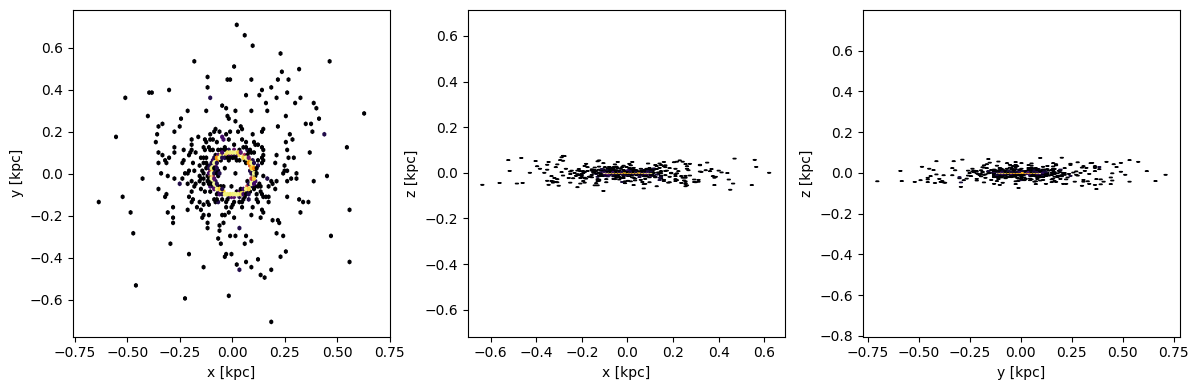

In [6]:
phase_space_coords = params_to_phasespace(params)

x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hexbin(x, y, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hexbin(x, z, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hexbin(y, z, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [7]:
target_phase_space_coords = params_to_phasespace(params, theta=theta_target)

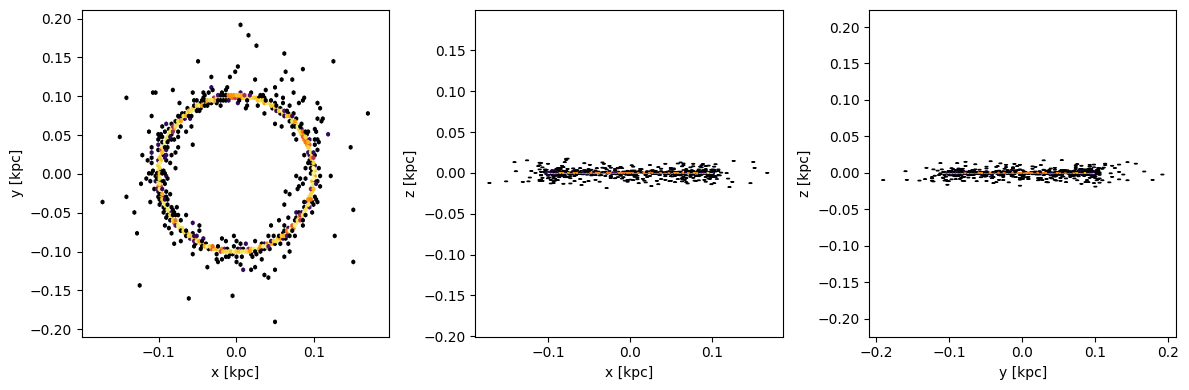

In [8]:
x_target = target_phase_space_coords[:, 0]
y_target = target_phase_space_coords[:, 1]
z_target = target_phase_space_coords[:, 2]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hexbin(x_target, y_target, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hexbin(x_target, z_target, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hexbin(y_target, z_target, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [9]:
@jax.jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

In [10]:
@jax.jit
def loss_function(params, theta_init, theta_target):
    #theta_source = jnp.array([theta[0], theta[1], theta[2]])
    theta = jnp.array([theta_init[0]*1e12, theta_init[1]*20, theta_init[2]*20])
    theta_target = jnp.array([theta_target[0]*1e12, theta_target[1]*20, theta_target[2]*20])
    guess_phase_space = params_to_phasespace(params, theta=theta)
    target_phase_space = params_to_phasespace(params, theta=theta_target)

    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(guess_phase_space), len(target_phase_space)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D

    inin = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(guess_phase_space))(guess_phase_space))
    tata = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_phase_space))(target_phase_space))
    inta = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(guess_phase_space))(target_phase_space))
    
    loss = inin + tata - 2 * inta
    
    return loss

In [11]:
theta_init = jnp.array([1, 0.2, 0.2])
theta_target = jnp.array([1, 0.25, 0.17])
loss = loss_function(params, theta_init, theta_target)
print("Initial loss:", loss)

Initial loss: 0.00022207695096502895


In [12]:
@jax.jit
def compute_loss_and_grads(params, theta_init, theta_target):
    #theta_init = jnp.array([M, a, b])
    #theta_init = {'M': M, 'a': a, 'b': b}
    #theta = {'M': theta[0], 'a': theta[1], 'b': theta[2]}
    return jax.value_and_grad(lambda t: loss_function(params, t, theta_target))(theta_init)

In [13]:
loss, grads = compute_loss_and_grads(params, theta_init, theta_target)
#grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -1e3, 1e3), grads)
print("Loss:", loss)
print("Gradients:", grads)

Loss: 0.00022207695096502895
Gradients: [-5.41290330e-06  4.05463442e-05  4.06346758e-05]


In [14]:
import jax
import jax.numpy as jnp
import optax
from jax import value_and_grad

# Define the step logic without the decorator first
def step_logic(params, theta, theta_target, optimizer_state, optimizer):
    # 1. Calculate loss and gradients
    # loss_function must be visible in the global scope
    loss, grads = value_and_grad(loss_function, argnums=1)(params, theta, theta_target)
    
    # 2. Clip gradients
    grads = jnp.clip(grads, -1e3, 1e3)

    # 3. Compute optimizer updates and new state
    updates, optimizer_state = optimizer.update(grads, optimizer_state, theta)
    
    # 4. Apply updates
    theta = optax.apply_updates(theta, updates)
    
    return theta, loss, grads, updates, optimizer_state

# Explicitly apply jax.jit() with static_argnums=4
step = jax.jit(step_logic, static_argnums=4)


# The surrounding run_adam_optimizer function is fine and remains the same
def run_adam_optimizer(loss_function, params, theta_init, theta_target, learning_rate=1e-1, tol=1e-8, max_iter=10):
    # Assuming you want to use the parameter index [0] for M (the 1e12 term)
    optimizer = optax.adam(learning_rate)
    optimizer_state = optimizer.init(theta_init)

    theta = theta_init

    theta_history = []
    loss_history = []

    for i in range(max_iter):
        
        theta, loss, grads, updates, optimizer_state = step(
            params, theta, theta_target, optimizer_state, optimizer
        )

        loss_history.append(loss)
        theta_history.append(theta)
        
        print(f"Iteration {i}: Loss = {loss}, Theta = {theta}")

        if optax.global_norm(updates) < tol:
            print(f"Converged at iteration {i}")
            break
    
    return theta, loss, theta_history, loss_history

In [15]:
# Example execution using the new function name
theta_init = jnp.array([1, 0.2, 0.2001], dtype=jnp.float64) # Ensure float64 is used
theta_target = jnp.array([1, 0.202, 0.1999], dtype=jnp.float64)

theta_optimized, final_loss, theta_history, loss_history = run_adam_optimizer(loss_function, params, theta_init, theta_target)
# ... The rest of your execution logic

Iteration 0: Loss = 0.00022133959383417476, Theta = [1.09984377 0.10002089 0.10012085]
Iteration 1: Loss = 0.0002142409749975016, Theta = [1.18329011 0.00490549 0.00499202]
Iteration 2: Loss = 0.00021073236527180688, Theta = [ 1.2479102  -0.07341147 -0.07332584]
Iteration 3: Loss = 0.00021070976951870755, Theta = [ 1.30086392 -0.13749586 -0.13754073]
Iteration 4: Loss = 0.00021070952183264237, Theta = [ 1.34564273 -0.19169035 -0.1917838 ]
Iteration 5: Loss = 0.00021070933026199083, Theta = [ 1.38425691 -0.23845696 -0.23847279]
Iteration 6: Loss = 0.00021070916988937585, Theta = [ 1.41799919 -0.27930655 -0.27923547]
Iteration 7: Loss = 0.00021070904071812189, Theta = [ 1.44776517 -0.31527561 -0.31521004]
Iteration 8: Loss = 0.00021070893023646413, Theta = [ 1.47420944 -0.34716905 -0.34718147]
Iteration 9: Loss = 0.00021070883486077062, Theta = [ 1.49783012 -0.37563911 -0.37570768]


In [16]:
print(theta_history)

[Array([1.09984377, 0.10002089, 0.10012085], dtype=float64), Array([1.18329011, 0.00490549, 0.00499202], dtype=float64), Array([ 1.2479102 , -0.07341147, -0.07332584], dtype=float64), Array([ 1.30086392, -0.13749586, -0.13754073], dtype=float64), Array([ 1.34564273, -0.19169035, -0.1917838 ], dtype=float64), Array([ 1.38425691, -0.23845696, -0.23847279], dtype=float64), Array([ 1.41799919, -0.27930655, -0.27923547], dtype=float64), Array([ 1.44776517, -0.31527561, -0.31521004], dtype=float64), Array([ 1.47420944, -0.34716905, -0.34718147], dtype=float64), Array([ 1.49783012, -0.37563911, -0.37570768], dtype=float64)]


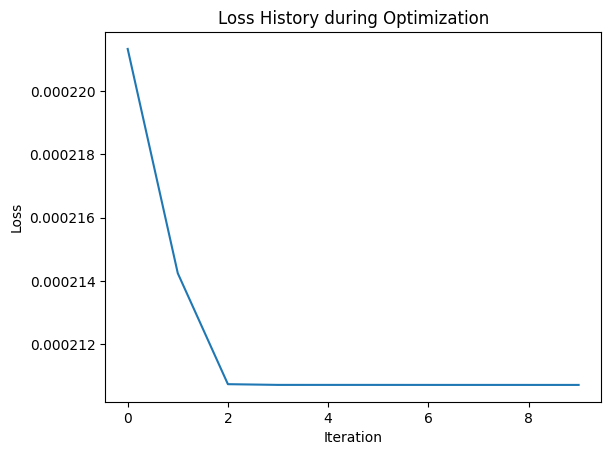

In [17]:
plt.figure()
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History during Optimization')
plt.show()

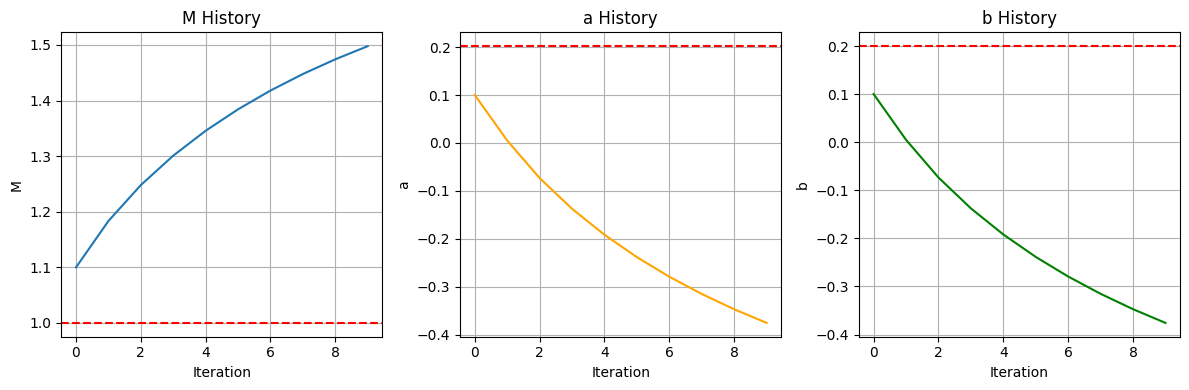

In [18]:
import matplotlib.pyplot as plt

# Extract M, a, and b from theta_history
M_history = [float(theta[0]) for theta in theta_history]
a_history = [float(theta[1]) for theta in theta_history]
b_history = [float(theta[2]) for theta in theta_history]

# Create subplots
plt.figure(figsize=(12, 4))

# Plot M
plt.subplot(1, 3, 1)
plt.plot(M_history, label='M')
plt.xlabel('Iteration')
plt.ylabel('M')
plt.title('M History')
plt.axhline(y=theta_target[0], color='red', linestyle='--', label='Target M')
plt.grid()

# Plot a
plt.subplot(1, 3, 2)
plt.plot(a_history, label='a', color='orange')
plt.xlabel('Iteration')
plt.ylabel('a')
plt.title('a History')
plt.axhline(y=theta_target[1], color='red', linestyle='--', label='Target a')
plt.grid()

# Plot b
plt.subplot(1, 3, 3)
plt.plot(b_history, label='b', color='green')
plt.xlabel('Iteration')
plt.ylabel('b')
plt.title('b History')
plt.axhline(y=theta_target[2], color='red', linestyle='--', label='Target b')
plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


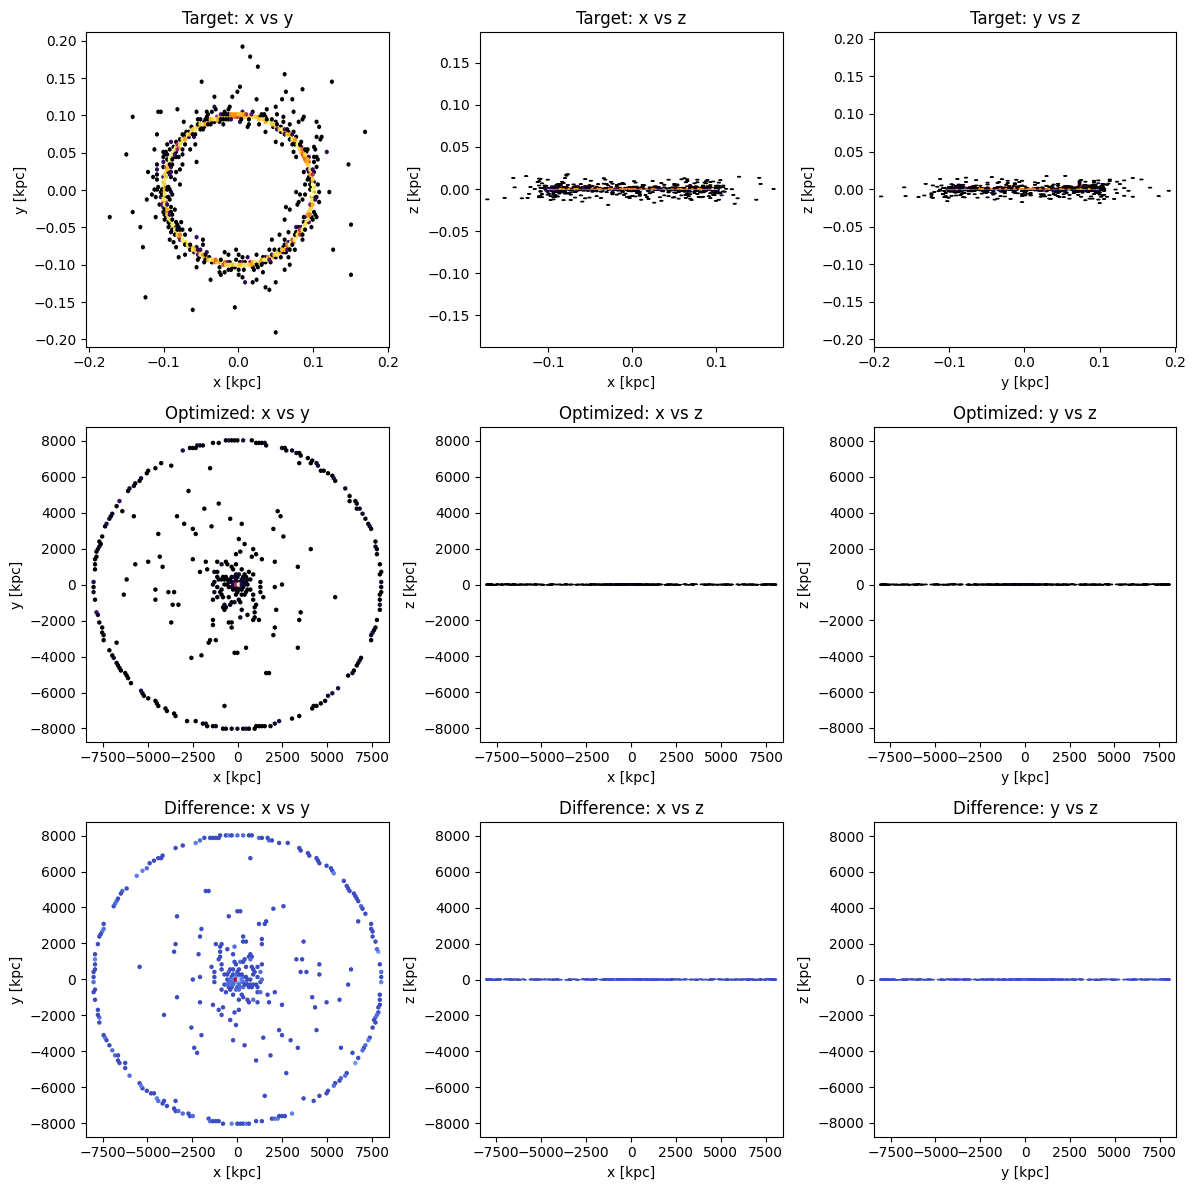

In [19]:
# Extract target phase space coordinates
x_target = target_phase_space_coords[:, 0]
y_target = target_phase_space_coords[:, 1]
z_target = target_phase_space_coords[:, 2]

# Extract optimized phase space coordinates
optimized_phase_space_coords = params_to_phasespace(params, theta=theta_optimized)
x_optimized = optimized_phase_space_coords[:, 0]
y_optimized = optimized_phase_space_coords[:, 1]
z_optimized = optimized_phase_space_coords[:, 2]

# Compute differences
x_diff = x_target - x_optimized
y_diff = y_target - y_optimized
z_diff = z_target - z_optimized

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# First row: Target
plt.subplot(3, 3, 1)
plt.hexbin(x_target, y_target, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Target: x vs y')
plt.axis('equal')

plt.subplot(3, 3, 2)
plt.hexbin(x_target, z_target, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.title('Target: x vs z')
plt.axis('equal')

plt.subplot(3, 3, 3)
plt.hexbin(y_target, z_target, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.title('Target: y vs z')
plt.axis('equal')

# Second row: Optimized
plt.subplot(3, 3, 4)
plt.hexbin(x_optimized, y_optimized, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Optimized: x vs y')
plt.axis('equal')

plt.subplot(3, 3, 5)
plt.hexbin(x_optimized, z_optimized, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.title('Optimized: x vs z')
plt.axis('equal')

plt.subplot(3, 3, 6)
plt.hexbin(y_optimized, z_optimized, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.title('Optimized: y vs z')
plt.axis('equal')

# Third row: Difference
plt.subplot(3, 3, 7)
plt.hexbin(x_diff, y_diff, gridsize=100, cmap='coolwarm', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Difference: x vs y')
plt.axis('equal')

plt.subplot(3, 3, 8)
plt.hexbin(x_diff, z_diff, gridsize=100, cmap='coolwarm', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.title('Difference: x vs z')
plt.axis('equal')

plt.subplot(3, 3, 9)
plt.hexbin(y_diff, z_diff, gridsize=100, cmap='coolwarm', bins='log')
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.title('Difference: y vs z')
plt.axis('equal')

plt.tight_layout()
plt.show()